## Load modules & Check PyTorch

In [2]:
# Import modules
import torch
import torch.nn as nn
import torch.optim as optim

from IPython.display import display, Markdown

import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# for noramlization
from sklearn.preprocessing import MinMaxScaler

## Parameters

In [3]:
# Debugger: Aktiviert
debug_mode = True
# Normalisierung der Daten: Deaktiviert
normalize_data = False
use_excel = False
max_input_pts = 20

# Trainingsdaten e_0:float=1.00, C_c:float=0.005, delta_epsilon:float=0.0005, sigma_t:float=1.00, max_n:int=50
oedo_parameter = {'e_0':1.00, 'C_c':0.005, 'delta_epsilon':0.0005, 'sigma_t':1.00, 'max_n':100, 'rand_epsilon':False}

## Preloaded Modules

In [4]:
def dict_to_markdown_table(data: dict, title: str = "Datenübersicht", include_index: bool = True, round_digits: int = 4):
    """
    Wandelt ein Dictionary mit Listenwerten in eine Markdown-Tabelle für Jupyter Notebooks um.
    
    - Schlüssel werden als Header genutzt
    - Erste Spalte ist ein Index, falls `include_index=True`
    - Einzelwerte werden als separate Tabelle unterhalb dargestellt
    - Zahlenwerte werden auf eine einstellbare Anzahl an Nachkommastellen gerundet

    :param data: Dictionary mit Key-Value-Paaren
    :param title: Überschrift für die Tabelle
    :param include_index: Falls True, wird eine Index-Spalte erstellt
    :param round_digits: Anzahl der Nachkommastellen, auf die Werte gerundet werden sollen
    :return: Markdown-String zur Anzeige in Jupyter
    """
    
    # Hilfsfunktion zum Runden von Zahlen
    def round_value(val):
        if isinstance(val, (int, float)):
            return round(val, round_digits)
        return val

    # Listen und einzelne Werte trennen
    list_data = {k: v for k, v in data.items() if isinstance(v, list)}
    single_values = {k: v for k, v in data.items() if not isinstance(v, list)}

    # Falls es Listen gibt, erstelle eine Tabelle mit Index
    if list_data:
        max_len = max(len(v) for v in list_data.values())  # Längste Liste bestimmen

        # Tabellenkopf
        md_table = f"### {title}\n\n"
        md_table += "| " + ("Index | " if include_index else "") + " | ".join(list_data.keys()) + " |\n"
        md_table += "|-" + ("-|" if include_index else "") + "-|".join(["-" * len(k) for k in list_data.keys()]) + "-|\n"

        # Datenzeilen
        for i in range(max_len):
            row = [str(i)] if include_index else []  # Index hinzufügen (optional)
            for key in list_data:
                if i < len(list_data[key]):
                    row.append(str(round_value(list_data[key][i])))
                else:
                    row.append("")  # Leere Werte für ungleich lange Listen
            md_table += "| " + " | ".join(row) + " |\n"
    
    else:
        md_table = ""

    # Einzelwerte als extra Tabelle darstellen
    if single_values:
        md_table += "\n\n#### Einzelwerte\n\n"
        md_table += "| " + " | ".join(single_values.keys()) + " |\n"
        md_table += "|-" + "-|".join(["-" * len(k) for k in single_values.keys()]) + "-|\n"
        md_table += "| " + " | ".join(map(lambda v: str(round_value(v)), single_values.values())) + " |\n"

    return Markdown(md_table)


def display_data_loss_table(data_dict, delta_sigma_pred, max_i):
    """
    Erstellt eine Markdown-Tabelle zur übersichtlichen Darstellung von Datenverlust.
    
    Unterstützt sowohl Python-Listen als auch NumPy-Arrays.
    
    :param data_dict: Dictionary mit `sigma_t` und `delta_sigma` (Listen oder np.arrays)
    :param delta_sigma_pred: Vorhergesagte Werte für `delta_sigma` (Liste oder np.array)
    :param max_i: Anzahl der Werte, die in der Tabelle angezeigt werden sollen
    """
    
    # Sicherstellen, dass `sigma_t` und `delta_sigma` existieren
    if "sigma_t" not in data_dict or "delta_sigma" not in data_dict or delta_sigma_pred is None:
        print("Fehler: `data_dict` oder `delta_sigma_pred` ist nicht korrekt definiert!")
        return

    # Konvertiere alle Werte zu Listen (falls sie NumPy-Arrays sind)
    def to_list(arr):
        return arr.tolist() if isinstance(arr, np.ndarray) else arr

    total_epsilon = to_list(data_dict["total_epsilon"])
    delta_epsilon = to_list(data_dict["delta_epsilon"])
    sigma_t = to_list(data_dict["sigma_t"])
    delta_sigma_true = to_list(data_dict["delta_sigma"])
    delta_sigma_pred = to_list(delta_sigma_pred.flatten())  # Falls `delta_sigma_pred` ein 2D-Array ist
    
    # Überprüfen, ob die Längen konsistent sind
    min_len = min(len(total_epsilon), len(sigma_t), len(delta_epsilon), len(delta_sigma_true), len(delta_sigma_pred), max_i)

    # Erstelle eine Tabelle für die übersichtliche Darstellung
    data_loss_table = {
        "total_epsilon" : list(total_epsilon[:min_len]), 
        "delta_epsilon" : list(delta_epsilon[:min_len]), 
        "sigma_t" : list(sigma_t[:min_len]), 
        "True delta_sigma": list(delta_sigma_true[:min_len]),
        "Predicted delta_sigma": list(delta_sigma_pred[:min_len]),
        "Test-Loss (True - Predicted)": list(np.round(np.array(delta_sigma_true[:min_len]) - np.array(delta_sigma_pred[:min_len]), 5))
    }

    # Markdown-Tabelle für bessere Darstellung in Jupyter
    display(dict_to_markdown_table(data_loss_table, title=f"Data-Loss bis sigma_{min_len-1}", include_index=True))

## Check for use of CONDA if available

In [5]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")

if device.type == 'cpu':
    device_num = 0
    print('No GPU available.')
else:
    device_num = torch.cuda.device_count()
    print('Device:', device, '-- Number of devices:', device_num)

No GPU available.


# Recurrent Neural Networks

Just as people do not have to think again each time about the things they have already learned, it is also possible to teach neural networks to recall knowledge they were being taught. This is done in so-called Recurrent Neural Networks (RNNs) with loops inside, which allow information to be retained. Currently the most used architectures of RNNs are Long short-term memory (LSTM) networks. LSTMs are RNNs that overcome the problem of long-term dependencies and thus have achieved the most state-of-the-art results in this area. In this exercise we will look at how to use LSTMs to predict future values using time series data sets.

## Data processing

### Ödometerdaten

| Index | sigma_t | delta_epsilon | delta_sigma |
|--|--------|--------------|------------|
| 0 | 1.0 | 0.0005 | 0.2 |
| 1 | 1.2 | 0.0005 | 0.24 |
| 2 | 1.44 | 0.0005 | 0.288 |
| 3 | 1.728 | 0.0005 | 0.3456 |
| 4 | 2.0736 | 0.0005 | 0.4147 |
| 5 | 2.4883 | 0.0005 | 0.4977 |
| 6 | 2.986 | 0.0005 | 0.5972 |
| 7 | 3.5832 | 0.0005 | 0.7166 |
| 8 | 4.2998 | 0.0005 | 0.86 |
| 9 | 5.1598 | 0.0005 | 1.032 |
| 10 | 6.1917 | 0.0005 | 1.2383 |
| 11 | 7.4301 | 0.0005 | 1.486 |
| 12 | 8.9161 | 0.0005 | 1.7832 |
| 13 | 10.6993 | 0.0005 | 2.1399 |
| 14 | 12.8392 | 0.0005 | 2.5678 |
| 15 | 15.407 | 0.0005 | 3.0814 |
| 16 | 18.4884 | 0.0005 | 3.6977 |
| 17 | 22.1861 | 0.0005 | 4.4372 |
| 18 | 26.6233 | 0.0005 | 5.3247 |
| 19 | 31.948 | 0.0005 | 6.3896 |
| 20 | 38.3376 | 0.0005 | 7.6675 |
| 21 | 46.0051 | 0.0005 | 9.201 |
| 22 | 55.2061 | 0.0005 | 11.0412 |
| 23 | 66.2474 | 0.0005 | 13.2495 |
| 24 | 79.4968 | 0.0005 | 15.8994 |
| 25 | 95.3962 | 0.0005 | 19.0792 |
| 26 | 114.4755 | 0.0005 | 22.8951 |
| 27 | 137.3706 | 0.0005 | 27.4741 |
| 28 | 164.8447 | 0.0005 | 32.9689 |
| 29 | 197.8136 | 0.0005 | 39.5627 |
| 30 | 237.3763 | 0.0005 | 47.4753 |
| 31 | 284.8516 | 0.0005 | 56.9703 |
| 32 | 341.8219 | 0.0005 | 68.3644 |
| 33 | 410.1863 | 0.0005 | 82.0373 |
| 34 | 492.2235 | 0.0005 | 98.4447 |
| 35 | 590.6682 | 0.0005 | 118.1336 |
| 36 | 708.8019 | 0.0005 | 141.7604 |
| 37 | 850.5622 | 0.0005 | 170.1124 |
| 38 | 1020.6747 | 0.0005 | 204.1349 |
| 39 | 1224.8096 | 0.0005 | 244.9619 |
| 40 | 1469.7716 | 0.0005 | 293.9543 |
| 41 | 1763.7259 | 0.0005 | 352.7452 |
| 42 | 2116.4711 | 0.0005 | 423.2942 |
| 43 | 2539.7653 | 0.0005 | 507.9531 |
| 44 | 3047.7183 | 0.0005 | 609.5437 |
| 45 | 3657.262 | 0.0005 | 731.4524 |
| 46 | 4388.7144 | 0.0005 | 877.7429 |
| 47 | 5266.4573 | 0.0005 | 1053.2915 |
| 48 | 6319.7487 | 0.0005 | 1263.9497 |
| 49 | 7583.6985 | 0.0005 | 1516.7397 |
| 50 | 9100.4382 | 0.0005 | 1820.0876 |
| 51 | 10920.5258 | 0.0005 | 2184.1052 |
| 52 | 13104.6309 | 0.0005 | 2620.9262 |
| 53 | 15725.5571 | 0.0005 | 3145.1114 |
| 54 | 18870.6685 | 0.0005 | 3774.1337 |
| 55 | 22644.8023 | 0.0005 | 4528.9605 |
| 56 | 27173.7627 | 0.0005 | 5434.7525 |
| 57 | 32608.5153 | 0.0005 | 6521.7031 |
| 58 | 39130.2183 | 0.0005 | 7826.0437 |
| 59 | 46956.262 | 0.0005 | 9391.2524 |
| 60 | 56347.5144 | 0.0005 | 11269.5029 |
| 61 | 67617.0172 | 0.0005 | 13523.4034 |
| 62 | 81140.4207 | 0.0005 | 16228.0841 |
| 63 | 97368.5048 | 0.0005 | 19473.701 |
| 64 | 116842.2058 | 0.0005 | 23368.4412 |
| 65 | 140210.6469 | 0.0005 | 28042.1294 |
| 66 | 168252.7763 | 0.0005 | 33650.5553 |
| 67 | 201903.3316 | 0.0005 | 40380.6663 |
| 68 | 242283.9979 | 0.0005 | 48456.7996 |
| 69 | 290740.7974 | 0.0005 | 58148.1595 |
| 70 | 348888.9569 | 0.0005 | 69777.7914 |
| 71 | 418666.7483 | 0.0005 | 83733.3497 |
| 72 | 502400.098 | 0.0005 | 100480.0196 |
| 73 | 602880.1176 | 0.0005 | 120576.0235 |
| 74 | 723456.1411 | 0.0005 | 144691.2282 |
| 75 | 868147.3693 | 0.0005 | 173629.4739 |
| 76 | 1041776.8432 | 0.0005 | 208355.3686 |
| 77 | 1250132.2118 | 0.0005 | 250026.4424 |
| 78 | 1500158.6542 | 0.0005 | 300031.7308 |
| 79 | 1800190.385 | 0.0005 | 360038.077 |
| 80 | 2160228.462 | 0.0005 | 432045.6924 |
| 81 | 2592274.1544 | 0.0005 | 518454.8309 |
| 82 | 3110728.9853 | 0.0005 | 622145.7971 |
| 83 | 3732874.7824 | 0.0005 | 746574.9565 |
| 84 | 4479449.7388 | 0.0005 | 895889.9478 |
| 85 | 5375339.6866 | 0.0005 | 1075067.9373 |
| 86 | 6450407.6239 | 0.0005 | 1290081.5248 |
| 87 | 7740489.1487 | 0.0005 | 1548097.8297 |
| 88 | 9288586.9784 | 0.0005 | 1857717.3957 |
| 89 | 11146304.3741 | 0.0005 | 2229260.8748 |
| 90 | 13375565.2489 | 0.0005 | 2675113.0498 |
| 91 | 16050678.2987 | 0.0005 | 3210135.6597 |
| 92 | 19260813.9585 | 0.0005 | 3852162.7917 |
| 93 | 23112976.7502 | 0.0005 | 4622595.35 |
| 94 | 27735572.1002 | 0.0005 | 5547114.42 |
| 95 | 33282686.5202 | 0.0005 | 6656537.304 |
| 96 | 39939223.8243 | 0.0005 | 7987844.7649 |
| 97 | 47927068.5891 | 0.0005 | 9585413.7178 |
| 98 | 57512482.307 | 0.0005 | 11502496.4614 |
| 99 | 69014978.7683 | 0.0005 | 13802995.7537 |


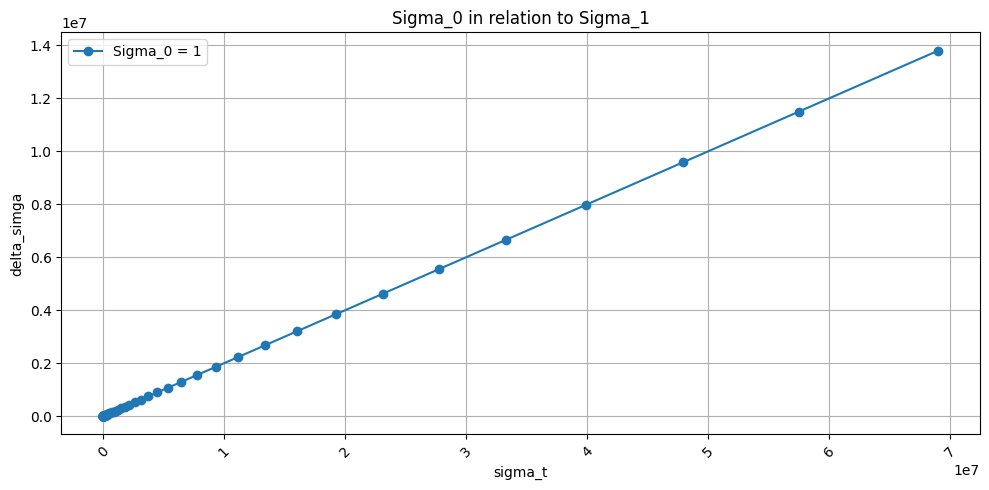

In [6]:
import random

class Oedometer:
    def __init__(self, e_0: float = 1.00, C_c: float = 0.005, delta_epsilon: float = 0.0005, 
                 sigma_t: float = 1.00, max_n: int = 50, rand_epsilon:bool=False, **kwargs):
        self.max_n = max_n

        # Standardwerte als Listen setzen
        self.e_0 = [e_0]
        self.C_c = [C_c]
        self.sigma_t = [sigma_t]
        self.delta_epsilon = []
        self.total_epsilon = [0]

        # Initiale Listen für Berechnungen
        self.sigma_t = [sigma_t]
        self.delta_sigma = []
        self.e_s = []
        self.delta_epsilon = [delta_epsilon]
        
        # Dynamische Zuweisung von kwargs, falls vorhanden
        for key, value in kwargs.items():
            if hasattr(self, key):  # Nur vorhandene Attribute setzen
                setattr(self, key, [value])
        
        # Berechnungen durchführen
        self.__calc_sigma_t_p1()

        # Listenlängen anpassen
        self.__adjust_list_lengths()
        self.__calc_total_epsilon()

    def __adjust_list_lengths(self):
        """ Passt ALLE Listen-Attribute an `max_n` an. """
        attributes = ['e_0', 'C_c', 'delta_epsilon', 'sigma_t', 'sigma_t', 'delta_sigma', 'e_s']
        for attr in attributes:
            value_list = getattr(self, attr, [])
            current_length = len(value_list)

            if current_length > self.max_n:
                setattr(self, attr, value_list[:self.max_n])  # Kürzen
            elif current_length < self.max_n:
                setattr(self, attr, value_list + [value_list[-1] if value_list else 0] * (self.max_n - current_length))  # Auffüllen
    
    def __calc_total_epsilon(self):
        for i in range(len(self.delta_epsilon)-1):
            self.total_epsilon.append(self.total_epsilon[i] + self.delta_epsilon[i])            
    
    def __calc_e_s(self, sigma_t):
        """ Berechnet `e_s` aus `sigma_t`. """
        e_s = (1 + self.e_0[0]) / self.C_c[0] * sigma_t
        self.e_s.append(e_s)
        return e_s

    def __calc_sigma_t_p1(self):
        """ Berechnet `sigma_t` und `delta_sigma` für die nächsten Schritte. """
        for i in range(self.max_n):  # -1, weil sigma_t bereits gesetzt ist
            e_s = self.__calc_e_s(self.sigma_t[i])
            delta_sigma = e_s * self.delta_epsilon[0]
            sigma = self.sigma_t[i] + delta_sigma
            self.sigma_t.append(sigma)
            self.delta_sigma.append(delta_sigma)

if not use_excel:
    data_dict_raw = dict(vars(Oedometer(**oedo_parameter)))

    # Leere Liste, um Datenzeilen zu sammeln
    data = {
        'sigma_t' : data_dict_raw['sigma_t'],
        'delta_epsilon' : data_dict_raw['delta_epsilon'],
        'delta_sigma' : data_dict_raw['delta_sigma'],
    }
    
    
    display(dict_to_markdown_table(data, 'Ödometerdaten'))
    

def plot_input():
    # Plot
    plt.figure(figsize=(10, 5))
    plt.plot(data_dict_raw['sigma_t'], data_dict_raw['delta_sigma'], marker='o', linestyle='-', label='Sigma_0 = 1')
    
    # Formatting
    plt.xlabel('sigma_t')
    plt.ylabel('delta_simga')
    plt.title('Sigma_0 in relation to Sigma_1')
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_input()

## Datenvorverarbeitung

Da wir zukünftige Datenpunkte in dieser Übung vorhersagen möchten, haben wir zuerst unsere Zeitreihen am Ende geschnitten und diesen Grenzwert als Testdaten behandeln.

In [10]:
# Split in X and Y
print(data)

# TODO**
x = np.array(data[:2], dtype=np.float32)
y = np.array(data[:, 3], dtype=np.float32)

print('x shape:', x.shape)
print('y shape:', y.shape)

{'sigma_t': [1.0, 1.2, 1.44, 1.728, 2.0736, 2.48832, 2.9859839999999997, 3.5831807999999996, 4.299816959999999, 5.159780351999999, 6.191736422399999, 7.430083706879999, 8.916100448256, 10.6993205379072, 12.83918464548864, 15.407021574586368, 18.48842588950364, 22.18611106740437, 26.62333328088524, 31.94799993706229, 38.337599924474745, 46.0051199093697, 55.206143891243634, 66.24737266949236, 79.49684720339084, 95.39621664406901, 114.47545997288282, 137.3705519674594, 164.84466236095128, 197.81359483314154, 237.37631379976983, 284.8515765597238, 341.8218918716686, 410.1862702460023, 492.22352429520276, 590.6682291542434, 708.801874985092, 850.5622499821104, 1020.6746999785325, 1224.809639974239, 1469.7715679690868, 1763.7258815629043, 2116.4710578754853, 2539.7652694505823, 3047.7183233406986, 3657.261988008838, 4388.714385610606, 5266.457262732727, 6319.748715279273, 7583.698458335128, 9100.438150002154, 10920.525780002585, 13104.630936003101, 15725.557123203722, 18870.668547844467, 22

KeyError: slice(None, 2, None)

Die *trva_data* werden jetzt normalisiert und in PyTorch Tensoren umgewandelt, wie aus den vorherigen Übungen bekannt. Der nächste Schritt ist jedoch besonders, indem Sequenzen aus den TRVA -Daten erstellt werden. Daher verwenden wir die Helferfunktion *create_inout_sequences (Eingabedaten, Zugfenster) *, wodurch Sequenzen $ Input \Rightarrow Output $ aus den Zeitreihen erstellt werden
So (falls Zugfenster = 3):

$$ [x_ {t-2}, x_ {t-1}, x_t] \rightarrow x_ {t+1}, $$

Die Eingangssequenzen haben die Länge *train_window* und die Ausgabe hat die Länge 1.

In [7]:
# Normalize data with MinMax Scaler

X = data[:, :2]  # sigma_t, delta_epsilon
y = data[:, 2:]  # delta_sigma

scaler_X = MinMaxScaler(feature_range=(-1, 1))
scaler_y = MinMaxScaler(feature_range=(-1, 1))

X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y)

In [8]:
# Convert to Torch Tensor
# view(-1) is similar to reshape for tensor and the array size is inferred for the -1 dimension

X_tensor = torch.FloatTensor(X_scaled)
y_tensor = torch.FloatTensor(y_scaled)

In [9]:
from torch.utils.data import TensorDataset, DataLoader

dataset = TensorDataset(X_tensor.view(-1, 1, 2), y_tensor.view(-1, 1))
train_loader = DataLoader(dataset, batch_size=1, shuffle=True)

## LSTM bauen

Sie erhalten die Klasse LSTM. Ein Blick auf die Vorwärtsmethode zeigt, dass der Eingang direkt in LSTM -Module fließt. Die Zahl kann über * num_lstm_layers * und ihre Größe durch verstecktes Dim ermittelt werden. Zusätzlich zum Ausgang haben die LSTM -Module auch einen versteckten Zellzustand. Auf die letzte LSTM -Schicht folgt eine lineare Ausgangsschicht. Beachten Sie, dass wir eine lineare Ausgangsschicht wie in der Regression verwenden, da die Ausgangswerte unbegrenzt sind.

In [10]:
# LSTM architecture
class LSTM(nn.Module):

    def __init__(self, input_dim, hidden_dim, batch_size, output_dim,
                    num_layers):
        super(LSTM, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.batch_size = batch_size
        self.num_layers = num_layers

        # Define the LSTM layer
        self.lstm = nn.LSTM(self.input_dim, self.hidden_dim, self.num_layers)

        # Define the output layer
        self.linear = nn.Linear(self.hidden_dim, output_dim)

    def init_hidden(self):
        # This is what we'll initialise our hidden state as
        return (torch.zeros(self.num_layers, self.batch_size, self.hidden_dim),
                torch.zeros(self.num_layers, self.batch_size, self.hidden_dim))

    def forward(self, input):
        # Forward pass through LSTM layer
        # Shape of lstm_out: [input_size, batch_size, hidden_dim]
        # Shape of self.hidden: (a, b), where a and b both 
        # Have shape (num_layers, batch_size, hidden_dim).
        lstm_out, self.hidden = self.lstm(input.view(len(input), self.batch_size, -1))
        
        # Only take the output from the final timestep
        # Can pass on the entirety of lstm_out to the next layer if it is a seq2seq prediction
        y_pred = self.linear(lstm_out[-1].view(self.batch_size, -1))
        return y_pred.view(-1)

## LSTM Instanz

In [11]:
# Create an instance of class LSTM

# TODO start**
input_dim = 2 # Feature dimension of input
hidden_dim = 32 # Number of hidden neurons in LSTM
batch_size = 1 # We do not merge the sequences into batches. Therefore the batch_size is 1.
output_dim = 1 # Feature dimension of output
num_lstm_layers =  1       
net = LSTM(input_dim, hidden_dim, batch_size, output_dim, num_lstm_layers)

In [12]:
# Send networks to GPU (if you have one which supports cuda) for faster computations

if device_num>1:
    print("Let's use", device_num, "GPU's")
    net = nn.DataParallel(net)
net.to(device) 
print(net)

LSTM(
  (lstm): LSTM(2, 32)
  (linear): Linear(in_features=32, out_features=1, bias=True)
)


In [13]:
# Specify hyperparameter loss function and optimizer
# TODO start**
num_epochs =  200 
num_learning_rate = 1e-4
loss_function = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr = num_learning_rate)
print(net)

LSTM(
  (lstm): LSTM(2, 32)
  (linear): Linear(in_features=32, out_features=1, bias=True)
)


## Training

Epoch 0/200: Train-Loss: 0.0
Epoch 1/200: Train-Loss: 0.0
Epoch 2/200: Train-Loss: 0.0
Epoch 3/200: Train-Loss: 0.0
Epoch 4/200: Train-Loss: 0.0
Epoch 5/200: Train-Loss: 0.0
Epoch 6/200: Train-Loss: 0.0
Epoch 7/200: Train-Loss: 0.0
Epoch 8/200: Train-Loss: 0.0
Epoch 9/200: Train-Loss: 0.0
Epoch 10/200: Train-Loss: 0.0
Epoch 11/200: Train-Loss: 0.0
Epoch 12/200: Train-Loss: 0.0
Epoch 13/200: Train-Loss: 0.0
Epoch 14/200: Train-Loss: 0.0
Epoch 15/200: Train-Loss: 0.0
Epoch 16/200: Train-Loss: 0.0
Epoch 17/200: Train-Loss: 0.0
Epoch 18/200: Train-Loss: 0.0
Epoch 19/200: Train-Loss: 0.0
Epoch 20/200: Train-Loss: 0.0
Epoch 21/200: Train-Loss: 0.0
Epoch 22/200: Train-Loss: 0.0
Epoch 23/200: Train-Loss: 0.0
Epoch 24/200: Train-Loss: 0.0
Epoch 25/200: Train-Loss: 0.0
Epoch 26/200: Train-Loss: 0.0
Epoch 27/200: Train-Loss: 0.0
Epoch 28/200: Train-Loss: 0.0
Epoch 29/200: Train-Loss: 0.0
Epoch 30/200: Train-Loss: 0.0
Epoch 31/200: Train-Loss: 0.0
Epoch 32/200: Train-Loss: 0.0
Epoch 33/200: Train-

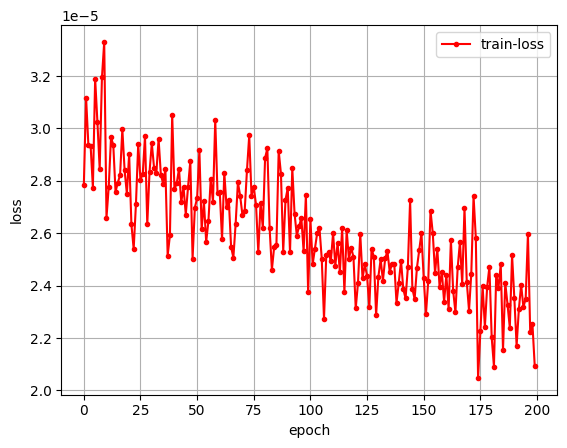

In [19]:
#%% Train the Model

loss_epoch_train = []

for epoch in range(num_epochs):
    loss_seq_train = []

    for seq, labels in train_loader:
        seq, labels = seq.to(device), labels.to(device)
        net.hidden = net.init_hidden()

        optimizer.zero_grad()
        y_pred_train = net(seq)

        loss = loss_function(y_pred_train, labels.view(-1))
        if torch.isnan(loss):  # Sicherheitscheck
            print(f"⚠️ NaN im Loss bei Epoch {epoch}")
            continue

        loss.backward()
        optimizer.step()

        loss_seq_train.append(loss.item())

    if loss_seq_train:
        loss_epoch_train.append(np.mean(loss_seq_train))
    else:
        print(f"⚠️ Epoch {epoch} hatte keine gültigen Samples.")
        loss_epoch_train.append(np.nan)

    print(f"Epoch {epoch}/{num_epochs}: Train-Loss: {np.round(loss_epoch_train[-1], 4)}")

plt.figure()
plt.plot(range(num_epochs), loss_epoch_train, color='r', marker='.', label = 'train-loss')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.grid(True)
plt.savefig('./results/main_lstm_loss.png')
plt.show()

## Testing

In [20]:
from torch.utils.data import TensorDataset, DataLoader

# Testdaten (z. B. letzte 10 Samples aus X_scaled und y_scaled)
X_test_tensor = torch.tensor(X_scaled[-10:], dtype=torch.float32).view(-1, 1, 2)
y_test_tensor = torch.tensor(y_scaled[-10:], dtype=torch.float32).view(-1, 1)

test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

# Vorhersagen sammeln
predictions_scaled = []
targets_scaled = []

net.eval()
with torch.no_grad():
    for seq, label in test_loader:
        seq = seq.to(device)
        net.hidden = net.init_hidden()
        prediction = net(seq)
        predictions_scaled.append(prediction.cpu().numpy())
        targets_scaled.append(label.cpu().numpy())


## Rückskalierung (inverse transform)

In [21]:
# Rückskalieren
predictions = scaler_y.inverse_transform(np.array(predictions_scaled).reshape(-1, 1))
targets = scaler_y.inverse_transform(np.array(targets_scaled).reshape(-1, 1))

# Ausgabe
for i, (pred, true) in enumerate(zip(predictions, targets)):
    print(f"[{i}]  vorhergesagt: {pred[0]:.4f} | tatsächlich: {true[0]:.4f}")

[0]  vorhergesagt: 2612422.2500 | tatsächlich: 2675113.0000
[1]  vorhergesagt: 3152736.0000 | tatsächlich: 3210135.7500
[2]  vorhergesagt: 3807544.7500 | tatsächlich: 3852162.7500
[3]  vorhergesagt: 4600593.0000 | tatsächlich: 4622595.0000
[4]  vorhergesagt: 5559122.5000 | tatsächlich: 5547114.5000
[5]  vorhergesagt: 6712734.0000 | tatsächlich: 6656537.5000
[6]  vorhergesagt: 8090361.5000 | tatsächlich: 7987844.5000
[7]  vorhergesagt: 9713948.0000 | tatsächlich: 9585413.0000
[8]  vorhergesagt: 11587203.0000 | tatsächlich: 11502497.0000
[9]  vorhergesagt: 13678856.0000 | tatsächlich: 13802996.0000


In [23]:
import numpy as np
import torch

# 🚀 Gegebene Eingabewerte
sigma_t = 1.0              # z. B. Anfangsspannung
delta_epsilon = 0.0005     # z. B. inkrementelle Dehnung

# 📦 Eingabewerte als NumPy-Array vorbereiten
X_input = np.array([[sigma_t, delta_epsilon]])

# 🔁 Normalisieren mit trainiertem scaler_X
X_input_scaled = scaler_X.transform(X_input)

# 🔄 In Tensor für das Modell umwandeln (seq_len=1, batch_size=1, input_dim=2)
X_tensor = torch.tensor(X_input_scaled, dtype=torch.float32).view(1, 1, 2).to(device)

# 🔮 Modellvorhersage ausführen
net.eval()
with torch.no_grad():
    net.hidden = net.init_hidden()
    delta_sigma_scaled = net(X_tensor).cpu().numpy()

# 🔁 Rückskalieren des Ergebnisses
delta_sigma = scaler_y.inverse_transform(delta_sigma_scaled.reshape(-1, 1))

# ✅ Ausgabe
print(f"Vorhergesagtes delta_sigma für sigma_t = {sigma_t} und delta_epsilon = {delta_epsilon}: {delta_sigma[0][0]:.6f}")

Vorhergesagtes delta_sigma für sigma_t = 1.0 und delta_epsilon = 0.0005: 11440.569336
